In [4]:
from google.colab import files
uploaded = files.upload()


Saving session_20251216_215921.csv to session_20251216_215921.csv


✅ Data loaded
   Time  SessionTime                                UserID       Category  \
0  0.00         0.00  11BD0B17-36B0-5843-9651-76B6F243E8DE   SessionStart   
1  0.00         0.00  11BD0B17-36B0-5843-9651-76B6F243E8DE    GameStarted   
2  0.10         0.10  11BD0B17-36B0-5843-9651-76B6F243E8DE  SliderChanged   
3  0.14         0.14  11BD0B17-36B0-5843-9651-76B6F243E8DE  SliderChanged   
4  0.18         0.18  11BD0B17-36B0-5843-9651-76B6F243E8DE  SliderChanged   

        Action       Target    Value  Details  
0        Scene  SampleScene      NaN      NaN  
1  SampleScene          NaN      NaN      NaN  
2   UI_Element         0.00  Default      NaN  
3   UI_Element         0.00  Default      NaN  
4   UI_Element         0.01  Default      NaN  

📊 Overview
Total events: 3105
Unique actions: ['Scene' 'SampleScene' 'UI_Element' 'Cube Interactable'
 'Tapered Interactable']
Unique targets: ['SampleScene' nan '0.00' '0.01' '0.02' '0.03' '0.04' '0.05' '0.06' '0.07'
 '0.08' '0.50' '

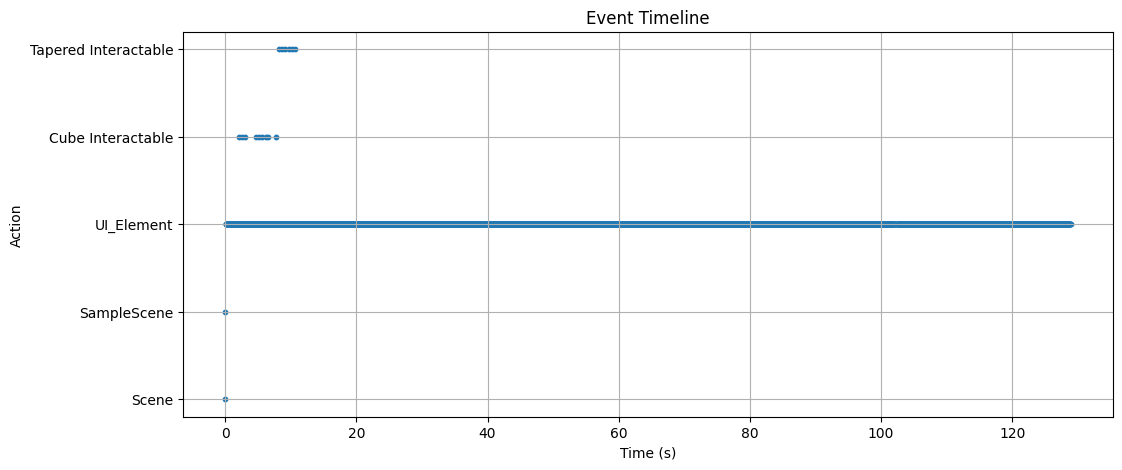


💾 Output files saved:
- gaze_summary.csv
- ui_summary.csv


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 1. Load data
# =========================
FILE_NAME = list(uploaded.keys())[0]  # Uploaded_File
df = pd.read_csv(FILE_NAME)

print("✅ Data loaded")
print(df.head())

# =========================
# 2. Basic cleanup
# =========================
df.columns = df.columns.str.strip()

# Convert TIME->SESSION TO NUMBER
df["Time"] = pd.to_numeric(df["Time"], errors="coerce")
df["SessionTime"] = pd.to_numeric(df["SessionTime"], errors="coerce")

# =========================
# 3. Overview
# =========================
print("\n📊 Overview")
print("Total events:", len(df))
print("Unique actions:", df["Action"].unique())
print("Unique targets:", df["Target"].unique())

# =========================
# 4. Gaze analysis
# =========================
gaze_df = df[df["Action"] == "GazeHold"]

gaze_summary = (
    gaze_df
    .groupby("Target")
    .agg(
        gaze_events=("Action", "count"),
        avg_value=("Value", "mean"),
        total_gaze_time=("Value", "sum")
    )
    .sort_values("total_gaze_time", ascending=False)
)

print("\n👀 Gaze Summary")
print(gaze_summary)

# =========================
# 5. Grab analysis
# =========================
grab_start = df[df["Action"] == "GrabStart"]
grab_end = df[df["Action"] == "GrabEnd"]

grab_counts = grab_start["Target"].value_counts()

print("\n✋ Grab Start Counts")
print(grab_counts)

# =========================
# 6. UI interaction analysis
# =========================
ui_df = df[df["Category"] == "UI_Element"]

ui_summary = (
    ui_df
    .groupby(["Action", "Target"])
    .size()
    .reset_index(name="Count")
    .sort_values("Count", ascending=False)
)

print("\n🖱️ UI Interaction Summary")
print(ui_summary)

# =========================
# 7. Timeline plot (events over time)
# =========================
plt.figure(figsize=(12, 5))
plt.scatter(df["Time"], df["Action"], s=10)
plt.xlabel("Time (s)")
plt.ylabel("Action")
plt.title("Event Timeline")
plt.grid(True)
plt.show()

# =========================
# 8. Gaze time bar chart
# =========================
if not gaze_summary.empty:
    gaze_summary["total_gaze_time"].plot(
        kind="bar",
        figsize=(10, 5),
        title="Total Gaze Time per Object"
    )
    plt.ylabel("Total Gaze Time")
    plt.show()

# =========================
# 9. Save processed summaries
# =========================
gaze_summary.to_csv("gaze_summary.csv")
ui_summary.to_csv("ui_summary.csv")

print("\n💾 Output files saved:")
print("- gaze_summary.csv")
print("- ui_summary.csv")


In [6]:
import pandas as pd
import numpy as np

# =========================
# Load data
# =========================
df = pd.read_csv(FILE_NAME)

# =========================
# Gaze features
# =========================
gaze = df[df["Action"] == "GazeHold"].groupby("Target").agg(
    gaze_events=("Action", "count"),
    total_gaze_time=("Value", "sum")
).reset_index()

# =========================
# Grab features
# =========================
grab = df[df["Action"] == "GrabStart"].groupby("Target").size().reset_index(name="grab_count")

# =========================
# Merge
# =========================
features = pd.merge(gaze, grab, on="Target", how="left")
features["grab_count"] = features["grab_count"].fillna(0)

# =========================
# Normalize
# =========================
for col in ["gaze_events", "total_gaze_time"]:
    features[col + "_norm"] = features[col] / features[col].max()

features["has_grab"] = (features["grab_count"] > 0).astype(int)

# =========================
# Importance score
# =========================
features["importance_score"] = (
    0.6 * features["total_gaze_time_norm"] +
    0.3 * features["gaze_events_norm"] +
    0.1 * features["has_grab"]
)

# =========================
# Labeling
# =========================
features["label"] = np.where(
    features["importance_score"] > 0.4,
    "Important",
    "Ignored"
)

print("🎯 Object Importance")
display(features[[
    "Target",
    "total_gaze_time",
    "gaze_events",
    "grab_count",
    "importance_score",
    "label"
]])

features.to_csv("object_importance.csv", index=False)


🎯 Object Importance


,Target,total_gaze_time,gaze_events,grab_count,importance_score,label


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['total_gaze_time']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'total_gaze_time'}, axis=1)
              .sort_values('total_gaze_time', ascending=True))
  xs = counted['total_gaze_time']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('total_gaze_time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('total_gaze_time')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['gaze_events']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'gaze_events'}, axis=1)
              .sort_values('gaze_events', ascending=True))
  xs = counted['gaze_events']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('gaze_events', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('gaze_events')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['grab_count']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'grab_count'}, axis=1)
              .sort_values('grab_count', ascending=True))
  xs = counted['grab_count']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('grab_count', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('grab_count')
_ = plt.ylabel('count()')